## Interactive multi-objective Bayesian optimization

This notebook enables you to interactively optimize multi-objective problems whose objective functions cannot be evaluated automatically, and is intended for use in problems with
* manual mesh generation and performance evaluation in computational fluid dynamics (CFD) and finite element analysis (FEA)
* experiment-based function evaluation where computational simulation is unavailable
* etc.

Copyright (c) 2022 Nobuo Namura  
This code is released under the MIT License.  
This Python code is for MBO-EPBII-SRVA and MBO-EPBII published in the following articles:

* [N. Namura, "Surrogate-Assisted Reference Vector Adaptation to Various Pareto Front Shapes for Many-Objective Bayesian Optimization," IEEE Congress on Evolutionary Computation, Krakow, Poland, pp.901-908, 2021.](https://doi.org/10.1109/TEVC.2017.2693320)
* [N. Namura, K. Shimoyama, and S. Obayashi, "Expected Improvement of Penalty-based Boundary Intersection for Expensive Multiobjective Optimization," IEEE Transactions on Evolutionary Computation, vol. 21, no. 6, pp. 898-913, 2017.](https://doi.org/10.1109/CEC45853.2021.9504917)

Please cite the article(s) if you use the code.  
This code was developed with Python 3.6.5.  
This code except below is released under the MIT License, see LICENSE.txt.  
The code in "EA_in_DEAP" is released under the GNU LESSER GENERAL PUBLIC LICENSE, see EA_in_DEAP/LICENSE.txt.

### 1. Setup

In [1]:
# must be edited
f_design_space = 'design_space.csv'     # file name (box constraints for design variables)
f_sample = 'sample1.csv'                # file name (training data)
MIN = [True, True]                      # True=Minimization, False=Maximization
n_add = 5                               # Number of additional sample points to be generated
# optimization method
CRITERIA = 'EPBII'                      # EPBII or EIPBII
NOISE = [False, False]                  # Use True if functions are noisy (Griewank, Rastrigin, DTLZ1, etc.)
VER2021 = True                          # True=2021 version, False=2017 version
SRVA = True                             # True=surrogate-assisted reference vector adaptation, False=two-layered simplex latice-design
OPTIMIZER = 'NSGA3'                     # NSGA3 or NSGA2 for ideal and nadir point determination (and reference vector adaptation if VER2021=True)
#reference vector for EPBII
n_randvec = 20                          # Number of adaptive reference vector (>=0)
nh = 0                                  # If VER2021=False, division number for the outer layer of the two-layered simplex latice-design (>=0)
nhin = 0                                # If VER2021=False, division number for the inner layer of the two-layered simplex latice-design (>=0)
#NSGA3 if OPTIMIZER=NSGA3:
n_randvec_nsga3 = 0                     # Number of random reference vector (>=0)
nh_nsga3 = 99                           # Division number for the outer layer of the two-layered simplex latice-design (>=0)
nhin_nsga3 = 0                          # Division number for the inner layer of the two-layered simplex latice-design (>=0)
ngen_nsga3 = 200                        # Number of generation in NSGA3
#NSGA2 if OPTIMIZER=NSGA2:
npop_nsga2 = 100                        # Number of population in NSGA2
ngen_nsga2 = 200                        # Number of generation in NSGA2

### 2. Initialization

In [2]:
from kriging import Kriging
gp = Kriging(MIN, CRITERIA, n_add, n_randvec, nh, nhin, n_randvec_nsga3, nh_nsga3, nhin_nsga3, ngen_nsga3, npop_nsga2, ngen_nsga2, VER2021, SRVA, OPTIMIZER, pbi_theta=1.0)
gp.read_sample(f_sample)
gp.normalize_x(f_design_space)

### 3. Model training: likelihood maximization with genetic algorithm (GA)
* theta0: hyperparameters in Kriging models have values in (0, 10**theta0]
* npop: number of population in GA
* ngen: maximum number of generation in GA
* mingen: minimum number of generation in GA
* STOP: True=training will be terminated if convergence condition is satisfied before ngen
* PRINT: True=print GA log

In [3]:
import warnings
warnings.simplefilter('ignore')
gp.kriging_training(theta0 = 3.0, npop = 500, ngen = 500, mingen=0, STOP=True, NOISE=NOISE, PRINT=False)

--- 1-th function estimation -------------------
--- 2-th function estimation -------------------


### 4. Additional sample generation: EPBII/EIPBII maximization with MOEA/D

In [4]:
import numpy as np
import pandas as pd
x_add, f_add_est = gp.kriging_infill(PLOT=False, PRINT=False)
add_sample = pd.DataFrame(np.hstack([x_add, f_add_est]), columns=np.hstack(['x'+np.arange(1,1+gp.nx).astype(str).astype(object), 'f'+np.arange(1,1+gp.nf).astype(str).astype(object), 'g'+np.arange(1,1+gp.ng).astype(str).astype(object)]))
add_sample

Multi-objective optimization on the Kriging models
Single objective optimization for the 1-th objective function
Single objective optimization for the 2-th objective function
EPBII maximization with MOEA/D


,x1,x2,f1,f2
0,0.217729,2.129447e-11,0.217729,0.366590
1,0.641905,7.644320e-12,0.641905,-0.418992
2,0.054602,6.750740e-12,0.054602,0.601770
3,0.843034,2.987359e-13,0.843034,-0.905030
4,0.424042,2.422346e-11,0.424042,0.018710


### 5. Visualization (2 and 3 objective cases)

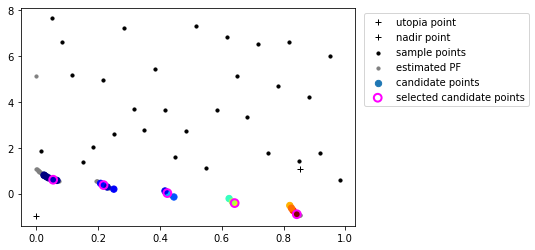

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

rank = gp.pareto_ranking(gp.f, gp.g)
if gp.nf == 2:
    plt.figure('test 2D Objective-space with '+str(gp.ns)+'-samples')
    plt.scatter(gp.f[:,0], gp.f[:,1], marker='o', c='black', s=10, label='sample points')
    plt.scatter(gp.f_opt[:,0], gp.f_opt[:,1], marker='o', c='grey', s=10, label='estimated PF')
    plt.plot(gp.utopia[0], gp.utopia[1], '+', c='black', label='utopia point')
    plt.plot(gp.nadir[0], gp.nadir[1], '+', c='black', label='nadir point')
    plt.scatter(gp.f_candidate[:,0], gp.f_candidate[:,1], c=gp.fitness_org, cmap='jet', marker='o', s=40, label='candidate points')
    plt.scatter(f_add_est[:,0],f_add_est[:,1], facecolors='none', edgecolors='magenta', marker='o', s=60, linewidth=2, label='selected candidate points')
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
elif gp.nf == 3:
    fig = plt.figure('3D Objective-space with '+str(gp.ns)+'-samples')
    ax = Axes3D(fig)
#    ax.scatter3D(gp.f[rank>1,0], gp.f[rank>1,1], gp.f[rank>1,2], marker='o', c='black', s=10, label='sample points')
#    ax.scatter3D(gp.f_opt[:,0], gp.f_opt[:,1], gp.f_opt[:,2], marker='o', c='grey', s=10, alpha=0.5, label='estimated PF')
    ax.scatter3D(gp.f[rank==1,0], gp.f[rank==1,1], gp.f[rank==1,2], marker='o', c='blue', s=20, label='NDSs among sample points')
    ax.scatter3D(gp.f_candidate[:,0], gp.f_candidate[:,1], gp.f_candidate[:,2], c=gp.fitness_org, cmap='jet', marker='*', s=40, label='candidate points')
    ax.scatter3D(f_add_est[:,0], f_add_est[:,1], f_add_est[:,-1], marker='o', c='none', edgecolor='magenta', s=60, linewidth=2, label='selected candidate points')
    ax.view_init(elev=30, azim=45)
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')

### File output
* Evaluate objective functions of the lowest n_add sample points and overwrite the generated file
* Return to "1. Setup" and use the file as "f_sample" for the next iteration

In [6]:
import os
import shutil
path, extension = os.path.splitext(f_sample)
f_sample_out =  path + '_' + str(gp.ns+n_add) + extension
shutil.copyfile(f_sample, f_sample_out)
with open(f_sample_out, 'a') as file:
    np.savetxt(file, x_add, delimiter=',')